In [100]:
from tokenizers import Tokenizer
import transformers
from bart_spektro.modeling_bart_spektro import BartSpektroForConditionalGeneration
from bart_spektro.configuration_bart_spektro import BartSpektroConfig
from dataset import SpectroDataCollator, SpectroDataset
import torch
import inspect
from metrics import compute_cos_simils, SpectroMetrics
from train_bart import build_tokenizer

# autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [114]:
def build_tokenizer(tokenizer_path: str) -> transformers.PreTrainedTokenizerFast:
    bpe_tokenizer = Tokenizer.from_file(tokenizer_path)

    tokenizer = transformers.PreTrainedTokenizerFast(tokenizer_object=bpe_tokenizer,
                                        bos_token="<bos>",
                                        eos_token="<eos>",
                                        unk_token="<ukn>",
                                        pad_token="<pad>",
                                        is_split_into_words=False)
    return tokenizer

In [115]:
tokenizer_path = "tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model"
bpe_tokenizer = Tokenizer.from_file(tokenizer_path)
tokenizer = build_tokenizer(tokenizer_path)

In [116]:
tokenizer.encode("<bos><nist><neims> COc1cc(C)c(cc1OC)Cl<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>")

[3,
 1234,
 1233,
 224,
 327,
 20,
 266,
 11,
 38,
 12,
 70,
 11,
 266,
 20,
 286,
 12,
 364,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2]

In [139]:
pred_smiles = "<bos><nist> Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C<eos><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>"
gt_smiles = "<nist> Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1<eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos><eos>"

pred_ids = tokenizer.encode(pred_smiles)
gt_ids = tokenizer.encode(gt_smiles)
pred_smiles, gt_smiles = tokenizer.decode(pred_ids, skip_special_tokens=True), tokenizer.decode(gt_ids, skip_special_tokens=True)
pred_smiles, gt_smiles


# pred_ids = torch.tensor(pred_ids).unsqueeze(0)
# gt_ids = torch.tensor(gt_ids).unsqueeze(0)

# pred_ids, gt_ids

(' Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C',
 ' Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1')

In [134]:
label_ids = [' CC1CCN(CC1N)Cc1ccns1)CC(C)C']
pred_ids = [' CC1CCN(CC1N)Cc1ccns1)CC(C)C']

In [135]:
metric = SpectroMetrics(tokenizer)
prediction = transformers.EvalPrediction(predictions=pred_ids, label_ids=gt_ids)
compute_cos_simils(label_ids, pred_ids)
# metric(prediction, )

[22:20:13] SMILES Parse Error: extra close parentheses while parsing: CC1CCN(CC1N)Cc1ccns1)CC(C)C
[22:20:13] SMILES Parse Error: Failed parsing SMILES ' CC1CCN(CC1N)Cc1ccns1)CC(C)C' for input: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
[22:20:13] SMILES Parse Error: extra close parentheses while parsing: CC1CCN(CC1N)Cc1ccns1)CC(C)C
[22:20:13] SMILES Parse Error: Failed parsing SMILES ' CC1CCN(CC1N)Cc1ccns1)CC(C)C' for input: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
ic| pred: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'
    true: ' CC1CCN(CC1N)Cc1ccns1)CC(C)C'


[0.0]

In [147]:

simil1 = " Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C"
simil2 = "Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1"
a,b,c = compute_cos_simils([simil1], [simil2], tokenizer)
display(b[0])
display(c[0])

[22:29:48] SMILES Parse Error: syntax error while parsing: <neims>
[22:29:48] SMILES Parse Error: Failed parsing SMILES '<neims>' for input: '<neims>'
ic| pred: ' Clc1ccc(c(c1)Cl)c1ccc(cc1)OC(=O)c1sccc1S(=O)(=O)N(C)C'
    true: '<neims> Cc1cc2c(c(=S)[nH]1)C(=O)OC2=Cc1ccc(Cl)c(Cl)c1'


None

None

In [143]:
config = BartSpektroConfig(vocab_size=len(tokenizer.get_vocab()), max_log_id=9)
model = BartSpektroForConditionalGeneration(config)
model.from_pretrained("checkpoints/bart_2023-04-07-18_27_23_30Mneims/checkpoint-1670000/")
None

KeyboardInterrupt: 

In [ ]:
model.

In [8]:
dataset = SpectroDataset("data/datasets/DEBUG/DEBUG_valid.jsonl")
loader = torch.utils.data.DataLoader(dataset, batch_size=2, collate_fn=SpectroDataCollator())

In [12]:
for batch in loader:
    preds = model.generate(input_ids=batch["input_ids"],
                           position_ids=batch["position_ids"],
                           attention_mask=batch["attention_mask"],
                           max_length=100,
                           num_gen)
    break

In [18]:
tokenizer.decode_batch(preds.tolist(), skip_special_tokens=False)

['<pad>NCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCCOCOCCOCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCCNCCCOCC<pad>',
 '<pad>FCCOCCNC23232323232323232323\x1aFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOCCNCFCCOC

In [29]:
list(filter(lambda x: x.startswith("<"), list(tokenizer.get_vocab().keys())))

['<bos>',
 '<eos>',
 '<source3>',
 '<pad>',
 '<trafo>',
 '<nist>',
 '<ukn>',
 '<source2>',
 '<',
 '<rassp>',
 '<source1>',
 '<neims>']

In [25]:
tokenizer.add_special_tokens(["<trafo>"])

1

In [27]:
tokenizer.save("tokenizer/bbpe_tokenizer/bart_bbpe_1M_tokenizer.model")

In [2]:
from torchdata.datapipes.iter import IterableWrapper, FileOpener, JsonParser
import os

json_files = ["data/datasets/DEBUG/DEBUG_train.jsonl"] 
datapipe1 = IterableWrapper(json_files)
datapipe2 = FileOpener(datapipe1, mode="b")

list(datapipe2)

[('data/datasets/DEBUG/DEBUG_train.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_train.jsonl'>>)]

In [39]:
dp = IterableWrapper(range(10))
list(dp)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [54]:
list(datapipe2)

[('data/datasets/DEBUG/DEBUG_train.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_train.jsonl'>>),
 ('data/datasets/DEBUG/DEBUG_valid.jsonl',
  StreamWrapper<<_io.BufferedReader name='data/datasets/DEBUG/DEBUG_valid.jsonl'>>)]

### DATAPIPES DEMO

In [2]:
import csv
import random

def generate_csv(file_label, num_rows: int = 5000, num_features: int = 20) -> None:
    fieldnames = ['label'] + [f'c{i}' for i in range(num_features)]
    writer = csv.DictWriter(open(f"sample_data{file_label}.csv", "w", newline=''), fieldnames=fieldnames)
    writer.writeheader()
    for i in range(num_rows):
        row_data = {col: random.random() for col in fieldnames}
        row_data['label'] = random.randint(0, 9)
        writer.writerow(row_data)

In [3]:
import numpy as np
import torchdata.datapipes as dp

def filter_for_data(filename):
    return "sample_data" in filename and filename.endswith(".csv")

def row_processor(row):
    return {"label": np.array(row[0], np.int32), "data": np.array(row[1:], dtype=np.float64)}

def build_datapipes(root_dir="."):
    datapipe = dp.iter.FileLister(root_dir)
    datapipe = datapipe.filter(filter_fn=filter_for_data)
    datapipe = datapipe.open_files(mode='rt')
    datapipe = datapipe.parse_csv(delimiter=",", skip_lines=1)
    # Shuffle will happen as long as you do NOT set `shuffle=False` later in the DataLoader
    datapipe = datapipe.shuffle()
    datapipe = datapipe.sharding_filter()  # !!! AFTER SHUFFLE, BEFORE EXPENSIVE OPERATIONS !!!
    datapipe = datapipe.map(row_processor)
    return datapipe

In [4]:
from torch.utils.data import DataLoader

if __name__ == '__main__':
    num_files_to_generate = 3
    for i in range(num_files_to_generate):
        generate_csv(file_label=i, num_rows=10, num_features=3)
    datapipe = build_datapipes()
    dl = DataLoader(dataset=datapipe, batch_size=5, num_workers=2)
    first = next(iter(dl))
    labels, features = first['label'], first['data']
    print(f"Labels batch shape: {labels.size()}")
    print(f"Feature batch shape: {features.size()}")
    print(f"{labels = }\n{features = }")
    n_sample = 0
    for row in iter(dl):
        n_sample += 1
    print(f"{n_sample = }")

Labels batch shape: torch.Size([5])
Feature batch shape: torch.Size([5, 3])
labels = tensor([2, 3, 9, 7, 8], dtype=torch.int32)
features = tensor([[0.4408, 0.9905, 0.0471],
        [0.5507, 0.3512, 0.5192],
        [0.9291, 0.2817, 0.8013],
        [0.2765, 0.6562, 0.9340],
        [0.6604, 0.9201, 0.0606]], dtype=torch.float64)
n_sample = 6


### My DATAPIPELINE

In [2]:
import json
import torch
from typing import List, Dict
from torch.utils.data import DataLoader
from dataset import SpectroDataCollator, SpectroDataset, load_all_datapipes
import yaml

# autoreload
%load_ext autoreload
%autoreload 2

In [7]:
# TRY IT OUT
with open("configs/train_config.yaml", "r") as f:
    try:
        config = yaml.safe_load(f)
    except yaml.YAMLError as exc:
        raise ValueError("Error in configuration file:", exc) from exc

collate_fn = SpectroDataCollator()
datapipes = load_all_datapipes(config["data_args"])
datapipes

# dl = DataLoader(dataset=datapipe, batch_size=1, num_workers=1, collate_fn=collate_fn)
# first = next(iter(dl))
# n_sample = 0
# for row in iter(dl):
#     print(row)
#     n_sample += 1
#     if n_sample == 20:
#         break
# print(f"{n_sample = }")

100
100
10
10
1
1


{'train': SampleMultiplexerDataPipe,
 'valid': {'debug1': MapperIterDataPipe, 'debug2': MapperIterDataPipe},
 'example': {'debug1': MapperIterDataPipe, 'debug2': MapperIterDataPipe}}

In [11]:
len(list(iter(datapipes["example"]["debug2"])))

('data/datasets/DEBUG/DEBUG_valid.jsonl', '{"smiles":"CCNC(c1cnn2c1OCCC2)CC=C=C","input_ids":[26,27,28,30,38,39,40,41,42,43,44,45,46,50,51,52,53,54,55,56,58,59,60,63,64,65,66,67,68,69,70,72,75,77,78,79,80,81,82,83,87,89,90,91,92,93,94,95,104,105,106,107,108,109,110,116,117,118,119,120,121,122,129,131,132,133,136,145,146,147,148,149,150,159,160,161,162,163,164,165,166,173,174,175,176,177,188,189,190,200,204,205,206,218,219,232,233,234,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2],"labels":[1233,224,283,11,70,20,284,21,70,20,378,21,12,261,32,38,32,38,0,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100,-100

1

In [19]:
import torchdata.datapipes as dp
from torch.utils.data import SequentialSampler

pipe = dp.iter.Sampler(datapipe)
# len(list(iter(pipe)))

NameError: name 'datapipe' is not defined

In [80]:
from dataset import load_all_datapipes

In [95]:
data_args ={
    "buffer_size": 1000, # for shuffling in dataloader
    "datasets": 
        {"30M_rassp": 
            {"train_path": "data/datasets/30M_rassp/30M_rassp_train.jsonl",
            "valid_path": "data/datasets/30M_rassp/30M_rassp_valid.jsonl",
            "weight": 1.0,
            "limit_val_split": 1000,
            "limit_example_split": 100},
        "nist":
            {"train_path": "data/datasets/NIST/NIST_split_filip/train_<nist>.jsonl",
            "valid_path": "data/datasets/NIST/NIST_split_filip/valid_<nist>.jsonl",
            "weight": 1.0,
            "limit_val_split": 1000,
            "limit_example_split": 100}
        }
}

datapipes = load_all_datapipes(data_args)

In [99]:
dl = DataLoader(dataset=datapipes["valid"]["30M_rassp"], batch_size=8, num_workers=1, collate_fn=collate_fn)
first = next(iter(dl))
n_sample = 0
for row in iter(dl):
    print(row)
    n_sample += 1
    if n_sample == 20:
        break
print(f"{n_sample = }")

{'input_ids': tensor([[17, 18, 26,  ...,  2,  2,  2],
        [30, 33, 34,  ...,  2,  2,  2],
        [28, 33, 34,  ...,  2,  2,  2],
        ...,
        [25, 26, 27,  ...,  2,  2,  2],
        [37, 38, 39,  ...,  2,  2,  2],
        [27, 28, 29,  ...,  2,  2,  2]]), 'position_ids': tensor([[ 3,  4,  4,  ..., -1, -1, -1],
        [ 4,  2,  2,  ..., -1, -1, -1],
        [ 2,  2,  3,  ..., -1, -1, -1],
        ...,
        [ 0,  2,  6,  ..., -1, -1, -1],
        [ 0,  5,  8,  ..., -1, -1, -1],
        [ 0,  0,  3,  ..., -1, -1, -1]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]]), 'decoder_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1,

In [1]:
datapipes

NameError: name 'datapipes' is not defined

In [13]:
tokenizer.pad_token_id

NameError: name 'tokenizer' is not defined

In [7]:
a = range(10)[None:4]
a

range(0, 4)

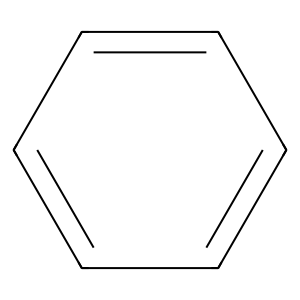

In [19]:
from rdkit import Chem
Chem.Draw.MolToImage(Chem.MolFromSmiles("C1=CC=CC=C1"))

In [21]:
# what is the path of python behind this notebook
import sys
sys.executable

'/home/xhajek9/miniconda3/envs/BARTtrain/bin/python'

In [25]:
import rdkit.Chem.Draw


In [27]:
from rdkit.Chem import Draw, MolFromSmiles

### Callback debug

In [30]:
from __future__ import annotations

import math
import pathlib
import shutil
from typing import Callable, Iterable

from tqdm.auto import tqdm
import pandas as pd
import transformers
import tokenizers
import wandb
import torch
import torch.utils.data
import warnings
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, MolFromSmiles, RDKFingerprint

In [34]:
pred_mol = Chem.MolFromSmiles("C1=CC=CC=C1")
type(pred_mol)

rdkit.Chem.rdchem.Mol

In [38]:
from callbacks import PredictionLogger # compute_cos_simils

ImportError: attempted relative import with no known parent package

In [45]:
a = {"a":2, "b":3}
x = a.get("c", None) 

In [46]:
x is None

True

In [149]:
transformers.Trainer()

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
Found safetensors installation, but --save_safetensors=False. Safetensors should be a preferred weights saving format due to security and performance reasons. If your model cannot be saved by safetensors please feel free to open an issue at https://github.com/huggingface/safetensors!
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


RuntimeError: `Trainer` requires either a `model` or `model_init` argument